# Machine Learning Dataset
This notebook will go through the steps of downloading MMS data for the machine learning project and creating a CSV file of the results. It will also be a small introduction to the structure of CDF files.

## Creating the pymms object
First, we create an instance of the object that communicates with the SDC. For the sake of this example, we will start with data from `2015-10-16` because there are several magnetopause crossings and a well-studied electron diffusion region event. Also, for simplicity we will work with data from the MMS1 spacecraft. Data from other spacecraft can be loaded by changing the `sc` property below to `'mms2'`, `'mms3'`, or `'mms4'`.

In [1]:
import numpy as np
import spacepy
from spacepy import pycdf
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pymms
from pymms import mms_utils
sdc = pymms.MrMMS_SDC_API()

# Define the spacecraft. We will use the variable later when accessing the CDF files.
sc = 'mms1'
start_date = '2015-10-16'
end_date = '2015-10-17'
data_root = '/Users/argall/data/' # Specifying data_root="~/" does not expand the tilde yet
                                  # However, if data_root=None, then ~/data is the default

# Set attributes
sdc.sc = sc
sdc.start_date = start_date
sdc.end_date = end_date
sdc.data_root = data_root

## FGM
The FGM dataset contains magnetic field data from the fluxgate magnetometer (FGM). [Since the Geocentric Solar Ecliptic](https://sscweb.gsfc.nasa.gov/users_guide/Appendix_C.html) (GSE) coordinate system is the standard for MMS data, we will extract non-scalar data in this system.

In [2]:
# First, define variables, as they will be used in creating variable names
coords = 'gse'
instr = 'fgm'
mode = 'srvy'
level = 'l2'

# Set object properties and get data
sdc.instr = instr
sdc.mode = mode
sdc.level = level
files = sdc.Download()

print('FGM Files:')
print(*files, sep='\n')

FGM Files:
/Users/argall/data/mms1/fgm/srvy/l2/2015/10/mms1_fgm_srvy_l2_20151016_v4.18.0.cdf


### CDF Files
CDF files are somewhat like netCDF or HDF5 files in that the contain data as well as metadata. Data is associated with variable names and variable metadata, or variable attributes. The file itself has metadata in the form of global attributes. For our purpose, we are interested in determining the variable names, what they mean, then selecting the subset of variables that are relevant to us. To do that, we will need `pycdf` from the `spacepy` package.

The most important variable attributes are `CATDESC`, which describes the variable, `FILLVAL`, which gives the value used for bad or missing data, and `DEPEND_[0-3]`, which list the dependent variables of a data variable. Typically, the dimensions of CDF variables are ordered as `[nRecs, nDep1, nDep2, nDep3]`, where `nRecs` is the total number of records, each record having dimensions `[nDep1, nDep2, nDep3]`. The value of `DEPEND_0` is typically `'Epoch'`, indicating that the CDF variable `'Epoch'` is a dependency. The `'Epoch'` variable contains a CDF Epoch time stamp at each of the `nRecs` number of records. Similarly `DEPEND_[1-3]` variables point to other variables in the CDF file that act as dependencies. If you want to plot a variable, you will need to also extract its `'DEPEND_0'` variables.

Variables and attributes are described in more detail in the [ISTP CDF Guidelines](https://spdf.gsfc.nasa.gov/sp_use_of_cdf.html).

In [3]:
# Open the file and pr
cdf = pycdf.CDF(files[0])

# Show global attribute
print('Global Attributes:')
for gAttrName in cdf.attrs:
    print('\t' + gAttrName)

# Show variable names
print('\nVariable Attributes:')
for varName in cdf:
    print('\t' + varName)

# Show variable attributes for a particular variable
print('\nVariable Attributes for "mms1_fgm_b_gse_srvy_l2":')
for vAttrName in cdf['mms1_fgm_b_gse_srvy_l2'].attrs:
    print('\t' + vAttrName)

# Important variable attributes:
print('\nValues of Important Variable Attributes:')
print('\t', 'CATDESC: ', cdf[sc+'_fgm_b_gse_srvy_l2'].attrs['CATDESC'])
print('\t', 'FILLVAL: ', cdf[sc+'_fgm_b_gse_srvy_l2'].attrs['FILLVAL'])
print('\t', 'DEPEND_0: ', cdf[sc+'_fgm_b_gse_srvy_l2'].attrs['DEPEND_0'])

Global Attributes:
	Project
	Source_name
	Discipline
	Data_type
	Descriptor
	File_naming_convention
	Data_version
	PI_name
	PI_affiliation
	TEXT
	Instrument_type
	Mission_group
	Logical_source
	Logical_file_id
	Logical_source_description
	Time_resolution
	Rules_of_use
	Generated_by
	Generation_date
	Acknowledgement
	MODS
	ADID_ref
	LINK_TEXT
	LINK_TITLE
	HTTP_LINK
	Parents

Variable Attributes:
	Epoch
	mms1_fgm_b_gse_srvy_l2
	mms1_fgm_b_gsm_srvy_l2
	mms1_fgm_b_dmpa_srvy_l2
	mms1_fgm_b_bcs_srvy_l2
	mms1_fgm_flag_srvy_l2
	Epoch_state
	mms1_fgm_r_gse_srvy_l2
	mms1_fgm_r_gsm_srvy_l2
	label_b_gse
	label_b_gsm
	label_b_dmpa
	label_b_bcs
	label_r_gse
	label_r_gsm
	represent_vec_tot
	mms1_fgm_hirange_srvy_l2
	mms1_fgm_bdeltahalf_srvy_l2
	mms1_fgm_stemp_srvy_l2
	mms1_fgm_etemp_srvy_l2
	mms1_fgm_mode_srvy_l2
	mms1_fgm_rdeltahalf_srvy_l2

Variable Attributes for "mms1_fgm_b_gse_srvy_l2":
	CATDESC
	DEPEND_0
	DISPLAY_TYPE
	FIELDNAM
	FILLVAL
	FORMAT
	LABL_PTR_1
	UNITS
	VALIDMIN
	VALIDMAX
	VAR_TYPE
	

### Reading Data
Now we can read data and its corresponding time stamps for a CDF variable. We choose the `'mms1_fgm_b_gse_srvy_l2'` variable because, as shown above, its `CATDESC` attribute describes it as the magnetic field in GSE coordinates. In order to be completely general, I will build the variable names from the attributes we have already defined. Variable names have the convention of `sc_instr_param_coords_optdesc_mode_level`, where `param` describes the quantity and `coords` is the coordinate system whenever relevant. Other components are similar to the file name conventions.

In [4]:
# Read the magnetic field and its time stamps
b_vname = '_'.join((sc, instr, 'b', coords, mode, level))
fgm_t = cdf[cdf[b_vname].attrs['DEPEND_0']][:]
fgm_b = cdf[b_vname][:]

# Close the CDF
cdf.close()

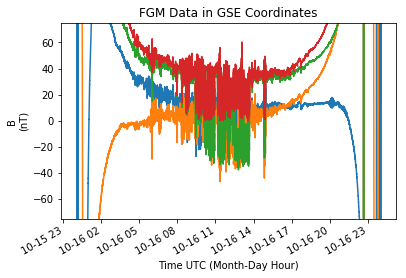

In [16]:
# Visualize the data
fig, ax = plt.subplots(1)
ax.plot(fgm_t, fgm_b)
fig.autofmt_xdate()

# Plot properties
ax.set_title('FGM Data in GSE Coordinates')
ax.set_ylim([-75,75])
ax.set_ylabel('B\n(nT)')
ax.set_xlabel('Time UTC (Month-Day Hour)')
ax.fmt_xdata = mdates.DateFormatter('%m-%d %H:%M')
plt.show()

## FPI
Next, we will repeat the process for the Fast Plasma Instrument (FPI), which consists of the Dual Electron Spectrometer (DES) and the Dual Ion Spectrometer (DIS). These measure characteristics of the electron and ion plasmas, respectively. Here, we are interested in the density, velocity, and temperature.

Normally, survey mode files are a combination of fast and slow survey data and span an entire day. Because FPI produces so much data, however, it is only operated in fast survey mode and its "daily files" are broken up into several files of shorter time intervals.

### DIS

In [25]:
# Update instrument-specific variables
instr = 'fpi'
mode = 'fast'
optdesc = 'dis-moms'

# Set attributes
sdc.instr = instr
sdc.mode = mode
sdc.optdesc = optdesc

# DIS variable names
n_vname = '_'.join((sc, 'dis', 'numberdensity', mode))
v_vname = '_'.join((sc, 'dis', 'bulkv', coords, mode))
t_para_vname = '_'.join((sc, 'dis', 'temppara', mode))
t_perp_vname = '_'.join((sc, 'dis', 'tempperp', mode))

# Open the file
files = sdc.Download()

# Read the data
dis_t = []
dis_n = []
dis_v = []
dis_temp_para = []
dis_temp_perp = []
print('DIS Files:')
for file in files:
    # Open the file
    cdf = pycdf.CDF(file)
    
    # Read the data
    #   - Convert numpyp arrays to lists to make appending easier
    dis_t += list(cdf[cdf[n_vname].attrs['DEPEND_0']][:])
    dis_n += list(cdf[n_vname][:])
    dis_v += list(cdf[v_vname][:])
    dis_temp_para += list(cdf[t_para_vname][:])
    dis_temp_perp += list(cdf[t_perp_vname][:])
    
    # Close the file
    cdf.close()
    print('  ' + file)

# Convert back to numpy arrays
dis_t = np.array(dis_t)
dis_n = np.array(dis_n)
dis_v = np.array(dis_v)
dis_temp_para = np.array(dis_temp_para)
dis_temp_perp = np.array(dis_temp_perp)

DIS Files:
  /Users/argall/data/mms1/fpi/fast/l2/dis-moms/2015/10/mms1_fpi_fast_l2_dis-moms_20151016040000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/dis-moms/2015/10/mms1_fpi_fast_l2_dis-moms_20151016060000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/dis-moms/2015/10/mms1_fpi_fast_l2_dis-moms_20151016080000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/dis-moms/2015/10/mms1_fpi_fast_l2_dis-moms_20151016100000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/dis-moms/2015/10/mms1_fpi_fast_l2_dis-moms_20151016120000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/dis-moms/2015/10/mms1_fpi_fast_l2_dis-moms_20151016140000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/dis-moms/2015/10/mms1_fpi_fast_l2_dis-moms_20151016160000_v3.1.0.cdf


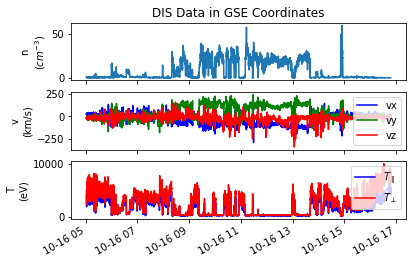

In [65]:
# Visualize the data
fig, ax = plt.subplots(nrows=3, ncols=1, squeeze=False)

fig.autofmt_xdate()

# Density
hn = ax[0,0].plot(dis_t, dis_n)
ax[0,0].set_title('DIS Data in GSE Coordinates')
ax[0,0].set_ylabel('n\n($cm^{-3}$)')

# Velocity
hvx, = ax[1,0].plot(dis_t, dis_v[:,0], 'b', label='vx')
hvy, = ax[1,0].plot(dis_t, dis_v[:,1], 'g', label='vy')
hvz, = ax[1,0].plot(dis_t, dis_v[:,2], 'r', label='vz')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('v\n(km/s)')

# Temperature
htpara, = ax[2,0].plot(dis_t, dis_temp_para, 'b', label='$T_{\parallel}$')
htperp, = ax[2,0].plot(dis_t, dis_temp_perp, 'r', label='$T_{\perp}$')
ax[2,0].legend(loc='upper right')
ax[2,0].set_ylabel('T\n(eV)')

plt.show()

### DES

In [66]:
# Update instrument-specific variables
optdesc = 'des-moms'

# Set attributes
sdc.optdesc = optdesc

# DIS variable names
n_vname = '_'.join((sc, 'des', 'numberdensity', mode))
v_vname = '_'.join((sc, 'des', 'bulkv', coords, mode))
t_para_vname = '_'.join((sc, 'des', 'temppara', mode))
t_perp_vname = '_'.join((sc, 'des', 'tempperp', mode))

# Open the file
files = sdc.Download()

# Read the data
des_t = []
des_n = []
des_v = []
des_temp_para = []
des_temp_perp = []
print('DES Files:')
for file in files:
    # Open the file
    cdf = pycdf.CDF(file)
    
    # Read the data
    des_t += list(cdf[cdf[n_vname].attrs['DEPEND_0']][:])
    des_n += list(cdf[n_vname][:])
    des_v += list(cdf[v_vname][:])
    des_temp_para += list(cdf[t_para_vname][:])
    des_temp_perp += list(cdf[t_perp_vname][:])

    # Close the file
    cdf.close()
    print('  ' + file)

# Convert back to numpy arrays
des_t = np.array(des_t)
des_n = np.array(des_n)
des_v = np.array(des_v)
des_temp_para = np.array(des_temp_para)
des_temp_perp = np.array(des_temp_perp)

DES Files:
  /Users/argall/data/mms1/fpi/fast/l2/des-moms/2015/10/mms1_fpi_fast_l2_des-moms_20151016040000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/des-moms/2015/10/mms1_fpi_fast_l2_des-moms_20151016060000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/des-moms/2015/10/mms1_fpi_fast_l2_des-moms_20151016080000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/des-moms/2015/10/mms1_fpi_fast_l2_des-moms_20151016100000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/des-moms/2015/10/mms1_fpi_fast_l2_des-moms_20151016120000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/des-moms/2015/10/mms1_fpi_fast_l2_des-moms_20151016140000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/l2/des-moms/2015/10/mms1_fpi_fast_l2_des-moms_20151016160000_v3.1.0.cdf


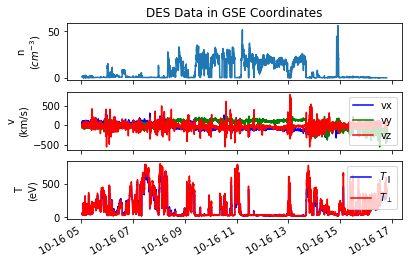

In [67]:
# Visualize the data
fig, ax = plt.subplots(nrows=3, ncols=1, squeeze=False)

fig.autofmt_xdate()

# Density
hn = ax[0,0].plot(des_t, des_n)
ax[0,0].set_title('DES Data in GSE Coordinates')
ax[0,0].set_ylabel('n\n($cm^{-3}$)')

# Velocity
hvx, = ax[1,0].plot(des_t, des_v[:,0], 'b', label='vx')
hvy, = ax[1,0].plot(des_t, des_v[:,1], 'g', label='vy')
hvz, = ax[1,0].plot(des_t, des_v[:,2], 'r', label='vz')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('v\n(km/s)')

# Temperature
htpara, = ax[2,0].plot(des_t, des_temp_para, 'b', label='$T_{\parallel}$')
htperp, = ax[2,0].plot(des_t, des_temp_perp, 'r', label='$T_{\perp}$')
ax[2,0].legend(loc='upper right')
ax[2,0].set_ylabel('T\n(eV)')

plt.show()

## Interpolate All Values to `t_des`
In this step, we need to get all variables into the same time basis. We will interpolate data from FGM and DIS onto the time tags of DES.

In [68]:
# Convert datetime objects to floats
des_t_stamp = [t.timestamp() for t in des_t]
fgm_t_stamp = [t.timestamp() for t in fgm_t]
dis_t_stamp = [t.timestamp() for t in dis_t]

# Interpolate FGM data
#   - An Nx4 array, ordered as (Bx, By, Bz, |B|)
nTimes = len(des_t_stamp)
nComps = np.size(fgm_b, 1)
fgm_b_interp = np.zeros([nTimes, nComps], dtype=float)
for idx in range(nComps):
    fgm_b_interp[:,idx] = np.interp(des_t_stamp, fgm_t_stamp, fgm_b[:,idx])

# Interpolate DIS data
dis_n_interp = np.interp(des_t_stamp, dis_t_stamp, dis_n)
dis_temp_para_interp = np.interp(des_t_stamp, dis_t_stamp, dis_temp_para)
dis_temp_perp_interp = np.interp(des_t_stamp, dis_t_stamp, dis_temp_perp)

# An Nx3 array, ordered as (Vx, Vy, Vz)
nComps = np.size(dis_v, 1)
dis_v_interp = np.zeros([nTimes, nComps])
for idx in range(nComps):
    dis_v_interp[:,idx] = np.interp(des_t_stamp, dis_t_stamp, dis_v[:,idx])

# Print results
print('Time:                   ', np.shape(des_t), des_t.dtype)
print('DES Density:            ', np.shape(des_n), des_n.dtype)
print('DES Velocity:           ', np.shape(des_v), des_v.dtype)
print('DES Temperature (para): ', np.shape(des_temp_para), des_temp_para.dtype)
print('DES Temperature (perp): ', np.shape(des_temp_perp), des_temp_perp.dtype)
print('FGM Magnetic Field:     ', np.shape(fgm_b_interp), fgm_b_interp.dtype)
print('DIS Density:            ', np.shape(dis_n_interp), dis_n_interp.dtype)
print('DIS Velocity:           ', np.shape(dis_v_interp), dis_v_interp.dtype)
print('DIS Temperature (para): ', np.shape(dis_temp_para_interp), dis_temp_para_interp.dtype)
print('DIS Temperature (perp): ', np.shape(dis_temp_perp_interp), dis_temp_perp_interp.dtype)

Time:                    (9297,) object
DES Density:             (9297,) float32
DES Velocity:            (9297, 3) float32
DES Temperature (para):  (9297,) float32
DES Temperature (perp):  (9297,) float32
FGM Magnetic Field:      (9297, 4) float64
DIS Density:             (9297,) float64
DIS Velocity:            (9297, 3) float64
DIS Temperature (para):  (9297,) float64
DIS Temperature (perp):  (9297,) float64


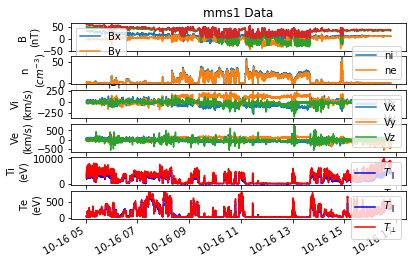

In [75]:
# Visualize the data
fig, ax = plt.subplots(nrows=6, ncols=1, squeeze=False)

fig.autofmt_xdate()

# Magnetic field
hn = ax[0,0].plot(des_t, fgm_b_interp)
ax[0,0].legend(labels=['Bx', 'By', 'Bz', '|B|'])
ax[0,0].set_title(sc + ' Data')
ax[0,0].set_ylabel('B\n(nT)')

# Density
hni, = ax[1,0].plot(des_t, dis_n_interp, label='ni')
hne, = ax[1,0].plot(des_t, des_n, label='ne')
ax[1,0].legend()
ax[1,0].set_ylabel('n\n($cm^{-3}$)')

# DIS Velocity
ax[2,0].plot(des_t, dis_v_interp)
ax[2,0].legend(labels=['Vx', 'Vy', 'Vz'])
ax[2,0].set_ylabel('Vi\n(km/s)')

# DES Velocity
hvx = ax[3,0].plot(des_t, des_v)
ax[3,0].legend(labels=['Vx', 'Vy', 'Vz'])
ax[3,0].set_ylabel('Ve\n(km/s)')

# DIS Temperature
htpara, = ax[4,0].plot(des_t, dis_temp_para_interp, 'b', label='$T_{\parallel}$')
htperp, = ax[4,0].plot(des_t, dis_temp_perp_interp, 'r', label='$T_{\perp}$')
ax[4,0].legend(loc='upper right')
ax[4,0].set_ylabel('Ti\n(eV)')

# DES Temperature
htpara, = ax[5,0].plot(des_t, des_temp_para, 'b', label='$T_{\parallel}$')
htperp, = ax[5,0].plot(des_t, des_temp_perp, 'r', label='$T_{\perp}$')
ax[5,0].legend(loc='upper right')
ax[5,0].set_ylabel('Te\n(eV)')

plt.show()

## Write to CSV File
The last step is to export this data to a CSV file.

In [ ]:
# Open file and write data
data = {
    'Time':  des_t,
    'DES Density' : des_n,
    'DES Velocity' : des_v,
    'DES Temperature (para)' : des_temp_para,
    'DES Temperature (perp)' : des_temp_perp,
    'FGM Magnetic Field' : fgm_b_interp,
    'DIS Density' : dis_n_interp,
    'DIS Velocity' : dis_v_interp,
    'DIS Temperature (para)' : dis_temp_para_interp,
    'DIS Temperature (perp)' : dis_temp_perp_interp,
}

data = pd.DataFrame(data)
data.to_csv("~/data/output.csv", index=False)

## SITL Selections
The actual selections that the SITL made are indicated by the start times of the burst file. These times are part of the file names themselves. To obtain the file names and parse the times,

In [29]:
# Open file and write data
sdc.instr = 'fpi'
sdc.mode = 'brst'
sdc.level = 'l2'
sdc.optdesc = 'dis-moms'
sitl_selections = [parts[5] for parts in mms_utils.parse_filename(sdc.FileNames())]
print(*sitl_selections, sep='\n')

20151016055934
20151016060044
20151016060204
20151016062101
20151016075744
20151016081914
20151016082334
20151016083804
20151016090134
20151016090304
20151016092224
20151016092404
20151016092534
20151016093114
20151016093234
20151016093404
20151016093554
20151016094344
20151016095304
20151016095404
20151016095724
20151016095844
20151016100144
20151016101954
20151016102534
20151016102944
20151016103254
20151016103414
20151016103654
20151016104424
20151016104554
20151016104834
20151016105454
20151016110934
20151016112554
20151016112754
20151016112914
20151016113844
20151016114004
20151016125604
20151016130224
20151016130334
20151016130524
20151016130904
20151016133344
20151016133904
20151016135404
20151016135534
20151016135714
20151016140544
20151016140704
20151016145004
20151016145104
20151016145244
20151016145354
20151016145534
